# Queue Imbalance as a One-Tick-Ahead Price Predictor in LOB


Order of this notebook is as follows:
1. [Data](#Data)
2. [Methodology](#Methodology)
3. [Results](#Results)
4. [Conclusions](#Conclusions)
5. [Other data](#Other-data)

Goal is to implement queue imbalance predictor from [[1]](#Resources).

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import numpy as np

import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks from 2013-09 - 2013-11. The market is open between 8-16 on weekdays, so we use the data from 9-15 to avoid having data affected by the abnormal trading behaviour, which usually occurs right after opening or closing auction. The tick size is $\pi = 0.01$ for the market, but the *relative tick size*(the ratio between stock price and $\pi$) for each stock differs.

To each stock data we introduce:

* bid price: $$ b(t) := \underset{\{x \in bidList(t) \}}{\max} x.price $$
* ask price: $$ a(t) := \underset{\{x \in askList(t)\}}{\min} x.price $$

* total size of active buy orders: $$ n^{b}(p, t) = \sum_{\{x \in buyList(t), p_x = p\}} x.volumen $$

* total size of active sell orders: $$ n^{a}(p, t) = \sum_{\{x \in askList(t), p_x = p\}} x.volumen $$


* mid price: $$ m(t) := \frac{a(t) + b(t)}{2} $$

* queue imbalance: $$ I(t) := \frac{n^b (b_t , t) - n^a (a_t, t)}{n^b (b_t , t) + n^a (a_t, t)} $$ where $a_t$ and $b_t$ are ask and bid prices for time $t$ respectively.

* mid price indicator: $$ y_i = \begin{cases} 1 & \text{if} & m(t_i) > m(t_{i-1})\\ 0 & \text{if} & m(t_i) < m(t_{i-1})\\ \end{cases} $$

Based on the **queue imbalance** we will try to predict **mid price indicator**

In [2]:
from lob_data_utils.roc_results import results #results_even_data as results

df_roc = pd.DataFrame()
df_roc['stock'] = results.keys()
df_roc['roc_area'] = results.values()

df_roc = df_roc.sort_values(by='roc_area', ascending=False)

dfs = {}
dfs_test = {}

stocks = df_roc['stock'].values

for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(s, cv=True, length=10000)
    if np.any(d):
        dfs[s] = d
        dfs_test[s] = d_test

In [3]:
stocks = dfs.keys()
print(len(stocks))

53


In [4]:
df_roc = pd.DataFrame()
df_roc['stock'] = [s for s in results.keys() if s in stocks]
df_roc['roc_area'] = [results[s] for s in results.keys() if s in stocks]
df_roc = df_roc.sort_values(by='roc_area', ascending=False)
df_roc.head()

,stock,roc_area
25,3035,0.583822
50,11946,0.582509
47,8080,0.582078
12,1956,0.581724
40,3879,0.578833


### Description of DataFrame

The data is indexed with time $t$.

* `bid` - bid queue
* `ask` - ask queue
* `bid_price` - bid price $b(t)$
* `ask_price` - ask price $a(t)$
* `mid_price` - mid price $m(t)$
* `sum_sell_ask` - total size of active sell orders for ask price  $ n^{a}(a(t), t) $
* `sum_buy_bid` - total size of active buy orders for bid price  $ n^{b}(b(t), t) $
* `mid_price_indicator` - the indicator if the mid price will rise in the **next** time tick
* `queue_imbalance` - $I(t)$

### Stock characteristic

For each stock we want to know how the can compare the *relative tick size* as the authors of [[1]](#Resources) saw it's is relevant for predictions. They decided that stocks are: 

* *large-tick stocks* when **maximal trade price** was below $50.00$
* *small-tick stocks* when **minimal trade price** was above $100.00$

They found out that the stocks which were between these two tresholds could behave similarily to both of these groups. 
    
The means of $n^{b}(b(t), t)$ and $n^{a}(a(t), t)$ for:

* *large-tick* stocks were above 3000 
* *small-tick* stocks were below 200

The bid ask spread for:

* *large-tick* stocks was below 0.02
* *small-tick* stocks was above 0.2

In [5]:
df_summary = pd.DataFrame(index=stocks)
sum_sell_ask_mean = []
sum_buy_bid_mean = []
max_trade_price = []
min_trade_price = []
bid_ask_spread = []
bid_len = []
ask_len = []
mean_bid_ask_len = []
mean_bid_len = []
mean_ask_len = []
from scipy.stats import pearsonr
for s in stocks:
    sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
    sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
    max_trade_price.append(max( dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
    min_trade_price.append(max( dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
    bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())

    max_len_bid = 0
    max_len_ask = 0
        
    for i, row in dfs[s].iterrows():
        if len(row['bid']) > max_len_bid:
            max_len_bid = len(row['bid'])
        if len(row['ask']) > max_len_ask:
            max_len_ask = len(row['ask'])
    bid_len.append(max_len_bid)
    ask_len.append(max_len_ask)

    sum_len_bid_ask = 0
    sum_len_bid = 0
    sum_len_ask = 0
    for i, row in dfs[s].iterrows():
        sum_len_bid_ask += (len(row['ask']) + len(row['bid']))
        sum_len_bid += len(row['bid'])
        sum_len_ask += len(row['ask'])
    mean_bid_ask_len.append(sum_len_bid_ask/(2 * len(dfs[s])))
    mean_bid_len.append(sum_len_bid/len(dfs[s]))
    mean_ask_len.append(sum_len_ask/len(dfs[s]))
df_summary['roc_area'] = df_roc['roc_area'].values
df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
df_summary['diff_mean_bid_ask'] = df_summary['sum_sell_ask_mean'] - df_summary['sum_buy_bid_mean']
df_summary['max_trade_price'] = max_trade_price
df_summary['min_trade_price'] = min_trade_price
df_summary['diff_trade_price'] = df_summary['max_trade_price'] - df_summary['min_trade_price']
df_summary['bid_ask_spread'] = bid_ask_spread
df_summary['len_ask'] = ask_len
df_summary['len_bid'] = bid_len
df_summary['mean_bid_ask_len'] = mean_bid_ask_len
df_summary['mean_bid_len'] = mean_bid_len
df_summary['mean_ask_len'] = mean_ask_len

df_summary.sort_values(by='bid_ask_spread')[df_summary['roc_area'] >= 0.56]

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len
1956,0.581724,7440.167167,8133.749667,-693.582500,306.4,273.4,33.0,0.153583,1040,846,681.739667,643.860333,719.619000
3161,0.560100,7886.097500,9571.136500,-1685.039000,419.8,358.7,61.1,0.164567,1268,1189,835.281833,838.427000,832.136667
11946,0.582509,16351.093000,16864.822333,-513.729333,206.1,183.6,22.5,0.173167,906,760,465.986750,463.804000,468.169500
3035,0.583822,6137.580500,5560.049667,577.530833,262.0,235.9,26.1,0.194967,810,717,518.150667,487.175500,549.125833
2813,0.564879,3902.674667,4752.606667,-849.932000,420.1,359.8,60.3,0.205900,1071,1150,689.949833,674.010833,705.888833
3022,0.572208,3283.534000,3873.401667,-589.867667,416.2,380.1,36.1,0.206883,1043,1122,782.255000,846.448833,718.061167
1388,0.566431,5509.877000,5589.935667,-80.058667,452.7,394.0,58.7,0.216000,1268,1478,954.476917,986.145000,922.808833
13003,0.563264,2469.830667,3284.500000,-814.669333,447.9,396.9,51.0,0.235350,1087,1073,659.238583,584.576000,733.901167
10508,0.567335,3710.705500,3863.016500,-152.311000,378.8,341.3,37.5,0.241700,719,817,541.163750,584.658833,497.668667
4060,0.563845,4062.935333,4430.731167,-367.795833,378.0,336.4,41.6,0.242717,1034,888,629.305833,613.310000,645.301667


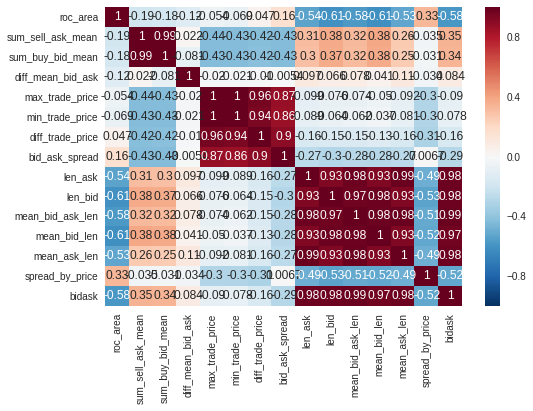

In [6]:
df_summary['spread_by_price'] = df_summary['bid_ask_spread'] / df_summary['diff_trade_price']
df_summary['bidask'] = (df_summary['len_bid'] + df_summary['len_ask'])/2
sns.heatmap(df_summary.corr(), annot=True)

In [7]:
print(df_summary['roc_area'].min(), df_summary['roc_area'].max())
df_summary[['roc_area', 'mean_bid_len',  'bidask']].sort_values(by='mean_bid_len')

0.523168940366 0.583821971588


,roc_area,mean_bid_len,bidask
11869,0.568009,407.641667,693.5
12417,0.574494,425.197167,604.0
1431,0.557967,426.659500,644.5
12456,0.576584,455.373833,765.5
11946,0.582509,463.804000,833.0
10484,0.545468,475.578167,711.0
4549,0.560937,476.083667,701.5
12255,0.565739,478.278333,768.0
3035,0.583822,487.175500,763.5
8080,0.582078,530.224667,763.5


In [8]:
df_summary[['roc_area', 'diff_mean_bid_ask', 'diff_trade_price', 
            'max_trade_price', 'min_trade_price',
            'spread_by_price']].sort_values(by='spread_by_price')

,roc_area,diff_mean_bid_ask,diff_trade_price,max_trade_price,min_trade_price,spread_by_price
9269,0.546032,226.764000,52.15,395.15,343.00,0.002199
9063,0.541335,766.982333,40.95,468.00,427.05,0.002345
9069,0.548773,4095.270333,45.60,308.70,263.10,0.002353
9265,0.546440,-90.481167,385.50,3549.00,3163.50,0.002436
10166,0.556248,-60.278167,486.00,3454.50,2968.50,0.002461
3161,0.560100,-1685.039000,61.10,419.80,358.70,0.002693
9061,0.547274,-448.303833,67.60,730.20,662.60,0.002766
9270,0.550734,-766.575833,223.00,2295.00,2072.00,0.002986
5836,0.547025,-65.215333,471.00,2850.00,2379.00,0.002987
9266,0.561259,-146.595500,257.00,1692.50,1435.50,0.003006


In [9]:
df_summary['spread_by_price_diff'] = df_summary['diff_trade_price'] *  df_summary['bid_ask_spread']
df_summary.corr()

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len,spread_by_price,bidask,spread_by_price_diff
roc_area,1.000000,-0.188093,-0.175071,-0.121236,-0.053807,-0.069219,0.046747,0.157408,-0.535401,-0.605719,-0.577364,-0.612359,-0.528890,0.331210,-0.578995,0.116034
sum_sell_ask_mean,-0.188093,1.000000,0.994720,0.021594,-0.435340,-0.433941,-0.422797,-0.431761,0.310085,0.376275,0.324411,0.384367,0.263816,-0.034552,0.347622,-0.329142
sum_buy_bid_mean,-0.175071,0.994720,1.000000,-0.081127,-0.431995,-0.430463,-0.420466,-0.429888,0.299160,0.368346,0.315454,0.379024,0.252171,-0.030984,0.337946,-0.328391
diff_mean_bid_ask,-0.121236,0.021594,-0.081127,1.000000,-0.019592,-0.020937,-0.010088,-0.005361,0.097168,0.066018,0.077565,0.040576,0.105567,-0.033731,0.083888,0.002516
max_trade_price,-0.053807,-0.435340,-0.431995,-0.019592,1.000000,0.998965,0.957360,0.873157,-0.098724,-0.076173,-0.074369,-0.050191,-0.091872,-0.304374,-0.089622,0.841744
min_trade_price,-0.069219,-0.433941,-0.430463,-0.020937,0.998965,1.000000,0.943231,0.862898,-0.088655,-0.064014,-0.062101,-0.037281,-0.080551,-0.300359,-0.078363,0.825408
diff_trade_price,0.046747,-0.422797,-0.420466,-0.010088,0.957360,0.943231,1.000000,0.895358,-0.157834,-0.149670,-0.148640,-0.129738,-0.159267,-0.314905,-0.156741,0.904094
bid_ask_spread,0.157408,-0.431761,-0.429888,-0.005361,0.873157,0.862898,0.895358,1.000000,-0.271738,-0.295817,-0.279667,-0.282975,-0.267482,0.006678,-0.288261,0.925745
len_ask,-0.535401,0.310085,0.299160,0.097168,-0.098724,-0.088655,-0.157834,-0.271738,1.000000,0.929553,0.978722,0.925228,0.989945,-0.490796,0.984044,-0.201749
len_bid,-0.605719,0.376275,0.368346,0.066018,-0.076173,-0.064014,-0.149670,-0.295817,0.929553,1.000000,0.969309,0.980010,0.927707,-0.534757,0.980321,-0.229325


In [10]:
df_by_len = df_summary.sort_values(by='len_bid')
df_by_len.head()

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len,spread_by_price,bidask,spread_by_price_diff
12417,0.574494,1972.152500,1864.290833,107.861667,323.2,287.8,35.4,0.296683,617,591,411.356917,425.197167,397.516667,0.008381,604.0,10.502590
11869,0.568009,476.664333,508.456167,-31.791833,2806.0,2410.0,396.0,2.155667,751,636,399.933333,407.641667,392.225000,0.005444,693.5,853.644000
12456,0.576584,754.949833,751.345833,3.604000,3735.0,3061.0,674.0,2.027667,860,671,478.209250,455.373833,501.044667,0.003008,765.5,1366.647333
10484,0.545468,2717.582500,2810.821333,-93.238833,358.4,316.2,42.2,0.288167,740,682,467.213917,475.578167,458.849667,0.006829,711.0,12.160633
1431,0.557967,540.248167,522.119500,18.128667,2757.0,2470.0,287.0,2.306333,600,689,414.739417,426.659500,402.819333,0.008036,644.5,661.917667


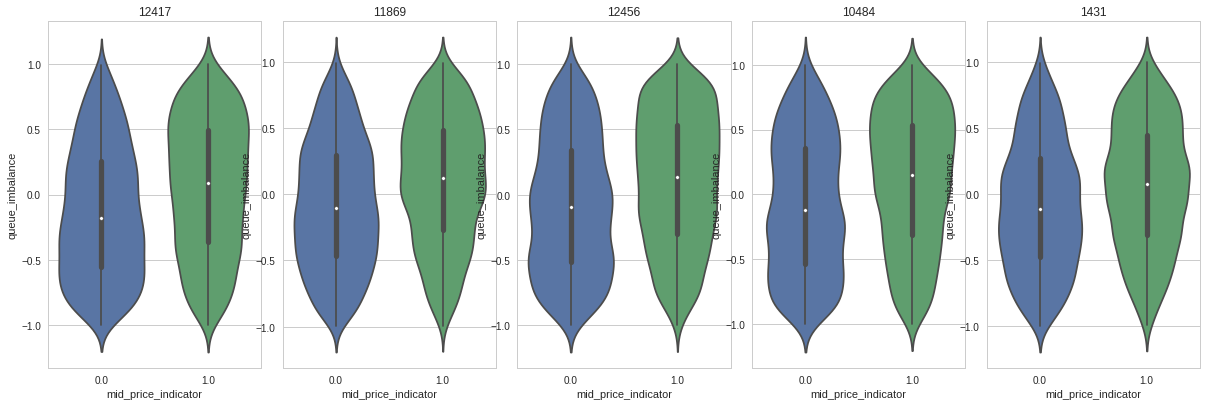

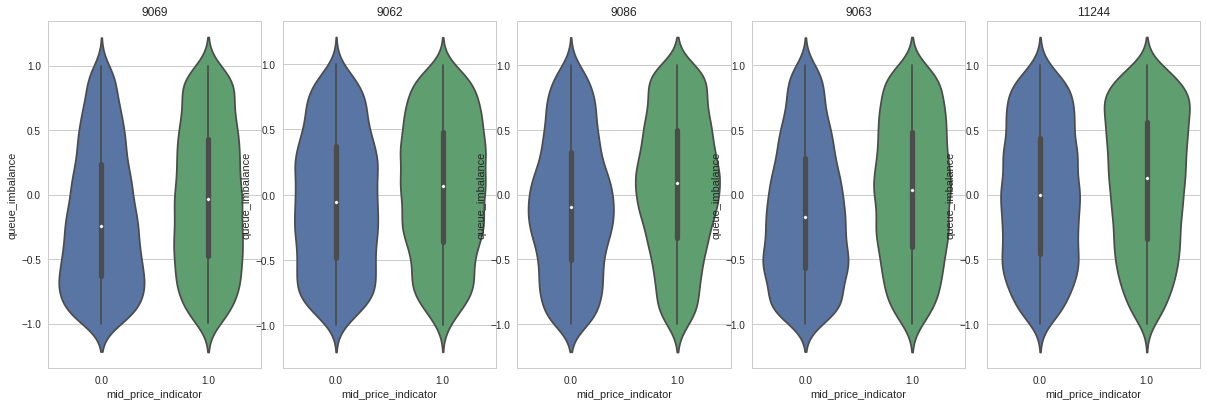

In [67]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=dfs[plot_stocks[i]], split=False, ax=axs[i],
                  label=plot_stocks[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=dfs[plot_stocks[i]], split=False, ax=axs[i],
                  label=plot_stocks[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

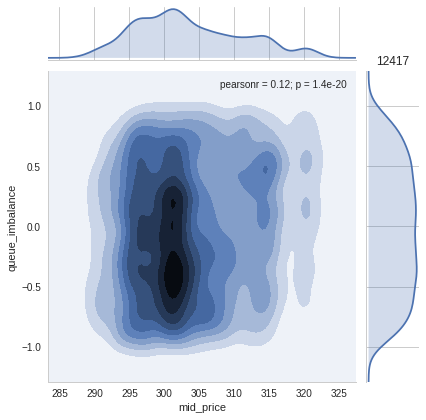

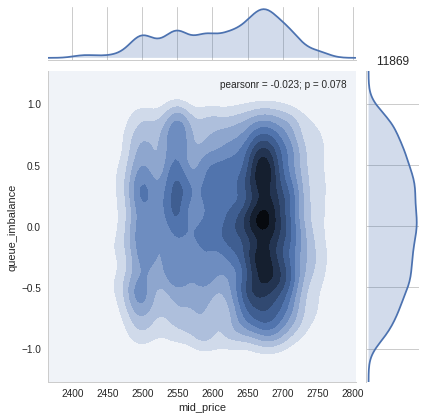

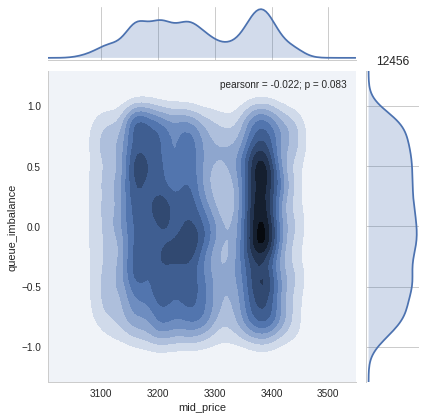

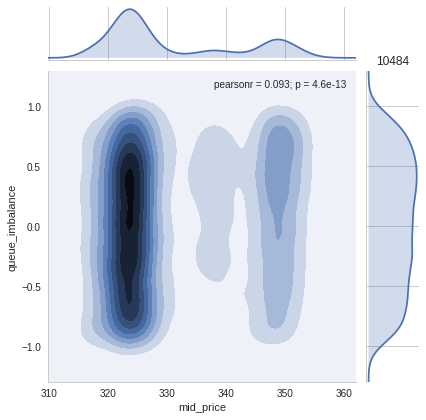

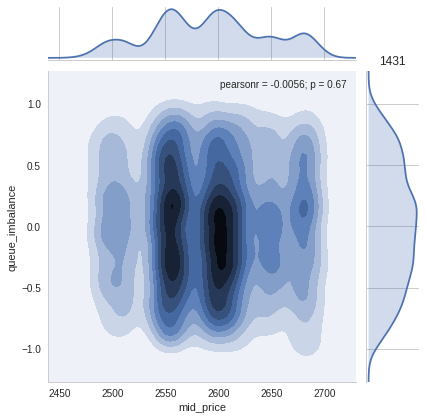

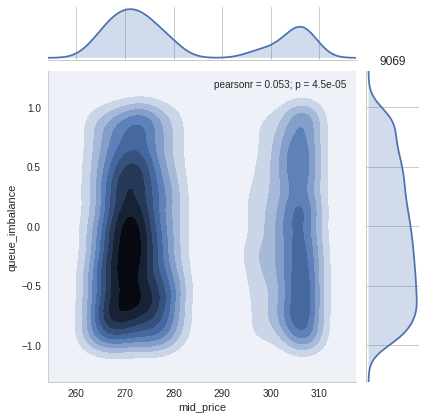

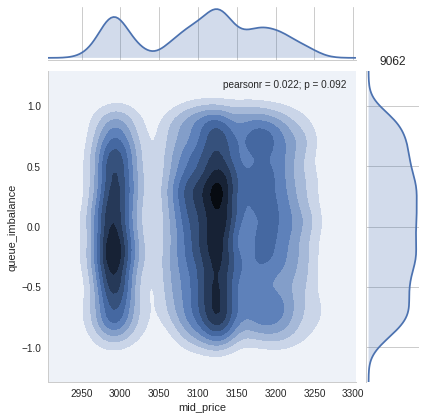

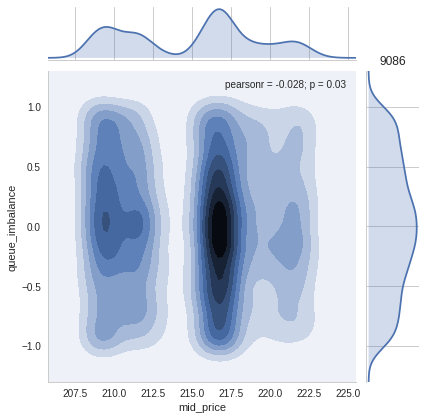

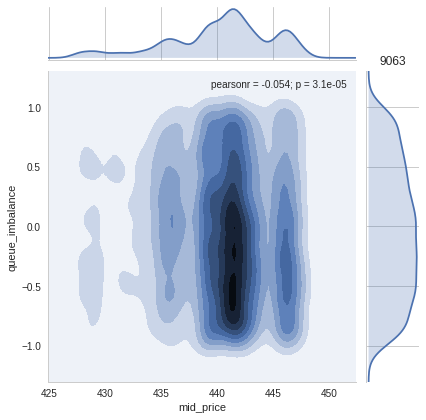

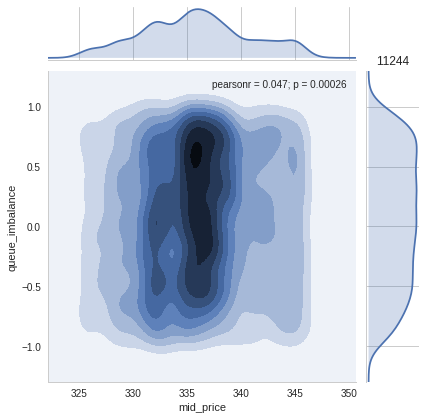

In [12]:
n = 5
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    sns.jointplot("mid_price", "queue_imbalance", data=dfs[plot_stocks[i]], 
                  kind='kde')
    plt.title(str(plot_stocks[i]))

plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    sns.jointplot("mid_price", "queue_imbalance", data=dfs[plot_stocks[i]], 
                  kind='kde')
    plt.title(str(plot_stocks[i]))
#     sns.jointplot(x="mid_price", y="queue_imbalance", 
#               data=df.loc[:, ['mid_price', 'queue_imbalance']], kind="kde")

Axes(0.125,0.125;0.133621x0.755)
Axes(0.285345,0.125;0.133621x0.755)
Axes(0.44569,0.125;0.133621x0.755)
Axes(0.606034,0.125;0.133621x0.755)
Axes(0.766379,0.125;0.133621x0.755)


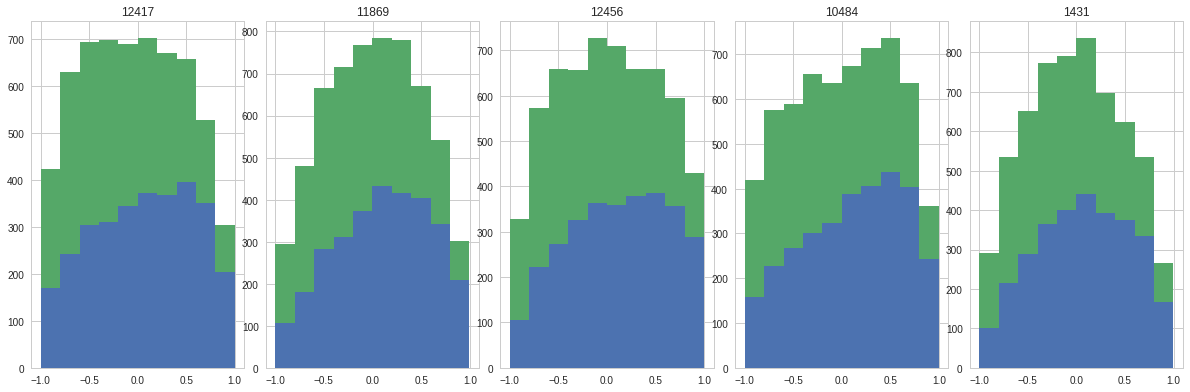

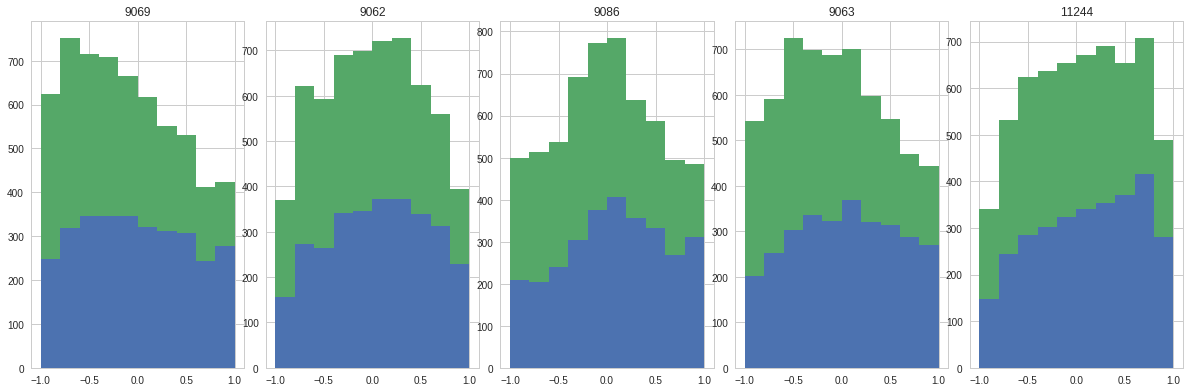

In [13]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    print(axs[i])
    axs[i].hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
                  df[df['mid_price_indicator']==0]['queue_imbalance']],
             stacked=True, label = ['will raise', 'will not raise'])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    axs[i].hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
                  df[df['mid_price_indicator']==0]['queue_imbalance']],
             stacked=True, label = ['will raise', 'will not raise'])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)




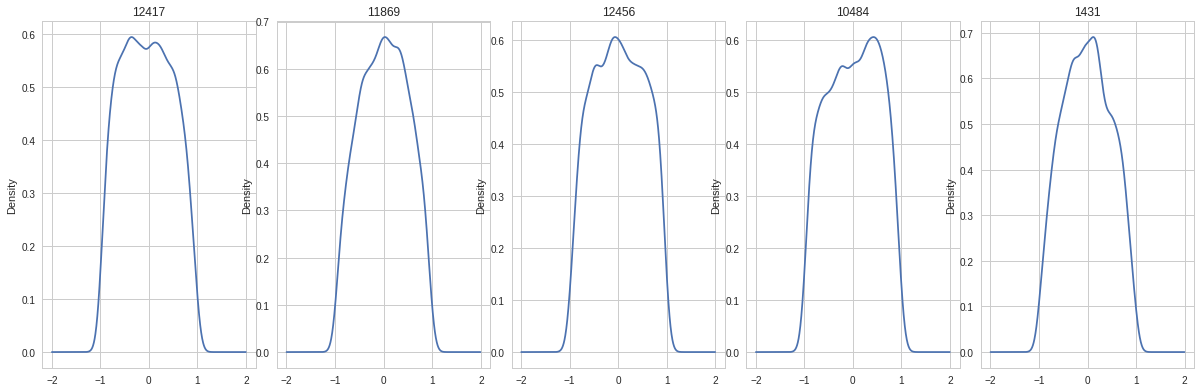

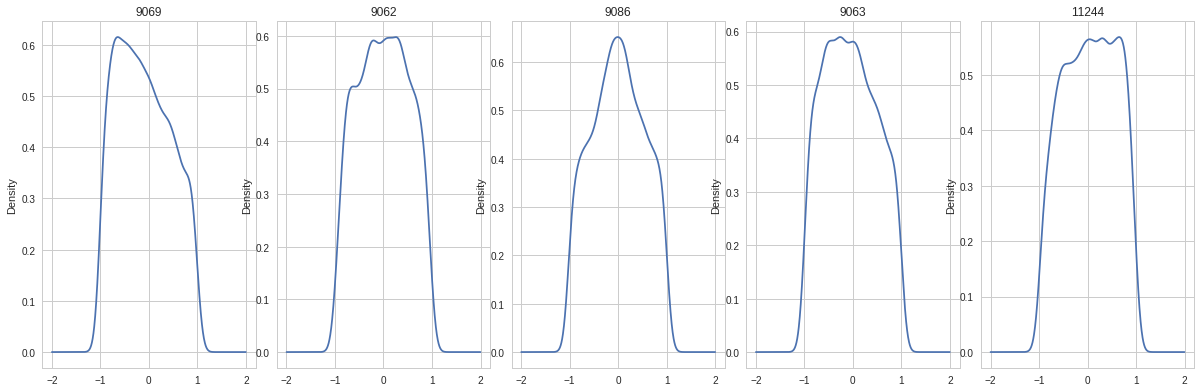

In [14]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    # df['mid_price'].plot('kde', ax=axs[i])
    df['queue_imbalance'].plot('kde', ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    # df['mid_price'].plot('kde', ax=axs[i])
    df['queue_imbalance'].plot('kde', ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

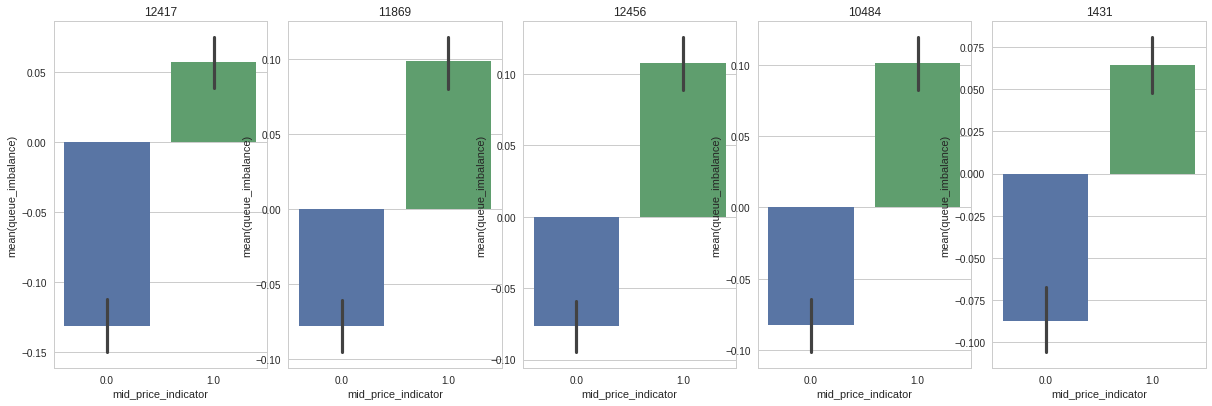

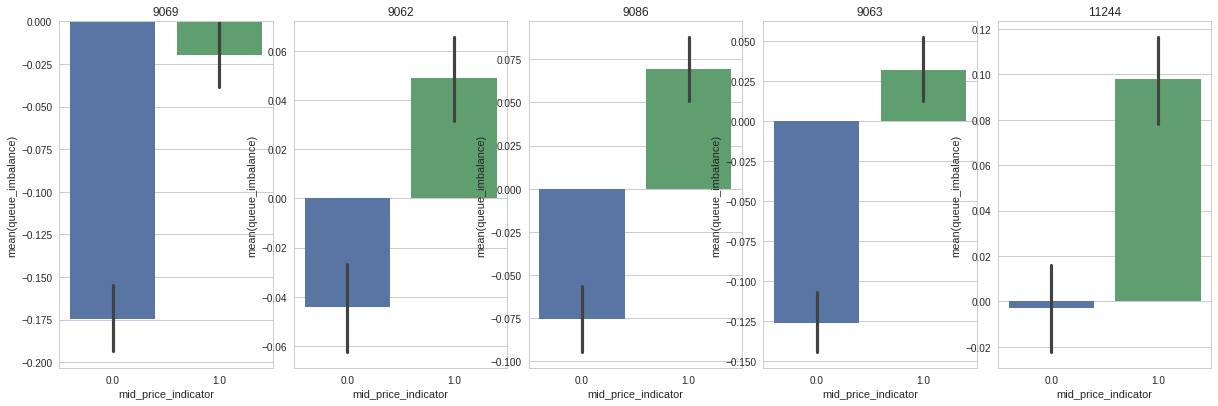

In [15]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df, ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df, ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

## Clustering data with all features

In [62]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=10).fit_predict(df_summary[['mean_bid_len']])

In [63]:
df_summary['class']= kmeans

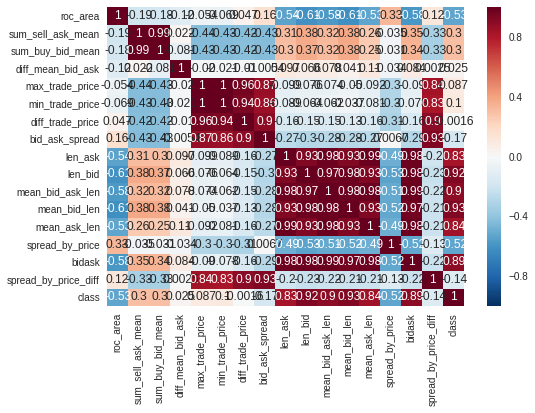

In [64]:
sns.heatmap(df_summary.corr(), annot=True)

In [65]:
df_summary[['roc_area', 'mean_bid_len', 'class']]

,roc_area,mean_bid_len,class
3035,0.583822,487.175500,0
11946,0.582509,463.804000,0
8080,0.582078,530.224667,0
1956,0.581724,643.860333,0
3879,0.578833,903.192500,1
12456,0.576584,455.373833,0
9268,0.575718,921.840500,1
4799,0.574800,705.098000,0
12417,0.574494,425.197167,0
4320,0.573487,605.978333,0
